# module import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets

# device 설정

In [2]:
#@title 기본 제목 텍스트
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version :', torch.__version__, ' Device :', DEVICE)

Using PyTorch version : 1.7.0+cu101  Device : cuda


# Hyper parameter 설정

In [3]:
class Config(dict): 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)


config = Config({
    'batch_size' : 32,
    'epochs': 30,
    'learning_rate': 0.01
})

# MNIST 데이터 다운로드
Train set과 Test set 분리하기

In [4]:
# MNIST 데이터 다운로드
train_dataset = datasets.MNIST(root="../data/MNIST",
                               train=True,
                               download=True,
                               transform=transforms.ToTensor())

test_dataset = datasets.MNIST(root="../data/MNIST",
                              train=False,
                              transform=transforms.ToTensor())


# 다운로드한 데이터를 Mini_Batch 단위로 분리해 저장
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=config.batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=config.batch_size,
                                          shuffle=False)

Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw


Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw


Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw


Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# 데이터 확인

In [5]:
for X_train, Y_train in train_loader:
    print('X_train :', X_train.size(), 'type :', X_train.type())
    print('Y_train :', Y_train.size(), 'type :', Y_train.type())
    break

X_train : torch.Size([32, 1, 28, 28]) type : torch.FloatTensor
Y_train : torch.Size([32]) type : torch.LongTensor


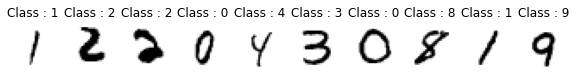

In [6]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap="gray_r")
    plt.title('Class : '+str(Y_train[i].item()))

# Model 설계하기

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 가로 크기 수 * 세로 크기 수 * 채널 수를 Input으로 받고,
        # 두 번째 레이어의 노드 수를 512개로 설정할 것이므로, Output을 512로 설정
        self.fc1 = nn.Linear(28*28, 512)
        # 노드 수가 512개이므로 input을 512, 세 번째 레이어의 노드수가 256이므로 아웃풋은 256으로 작성
        self.fc2 = nn.Linear(512, 256)
        # 노드 수가 256개이므로 input을 256개로, 아웃풋이 0~9까지여야 하므로 10으로 설정
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        # MNIST데이터는 28*28의 2차원 데이터이다.
        # 이를 28*28크기의 1차원 데이터로 flatten 해야 한다.
        # view를 이용한다.
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = nn.functional.sigmoid(x)
        x = self.fc2(x)
        x = nn.functional.sigmoid(x)
        x = self.fc3(x)
        x = nn.functional.log_softmax(x, dim=1)
        return x

# loss function, optimizer 설정하기

In [8]:
model = Net().to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=config.learning_rate,
                      momentum=0.5)

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


# MLP 모델 학습하는 함수 정의

In [9]:
def train(model, train_loader, optimizer, log_interval):
    model.train()

    for batch_idx, (image, lable) in enumerate(train_loader):
        image = image.to(DEVICE)
        lable = lable.to(DEVICE)
        optimizer.zero_grad()
        out = model(image)
        loss = loss_function(out, lable)
        loss.backward()
        optimizer.step()

        # if batch_idx % log_interval == 0:
        #     print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
        #         Epoch, batch_idx*len(image),
        #         len(train_loader.dataset), 100.*batch_idx / len(train_loader),
        #         loss.item()
        #     ))

# 학습하는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의

In [10]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    # 검증 과정 중에는 파라메터 값이 업데이트 되면 안되므로,
    # no_grad()를 이용하여, gradient의 흐름을 억제
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            out = model(image)
            test_loss += loss_function(out, label).item()
            prediction = out.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.*correct/len(test_loader.dataset)
    return test_loss, test_accuracy

# 학습 실행

In [11]:
test_accuracy_arr = []
for Epoch in range(1, config.epochs+1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print()
    print("[EPOCH: {}], \tTest Loss : {:.4f}, \tTest Accuracy : {:.2f} %\n".
          format(Epoch, test_loss, test_accuracy))
    test_accuracy_arr.append(test_accuracy)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



[EPOCH: 1], 	Test Loss : 0.0699, 	Test Accuracy : 10.38 %


[EPOCH: 2], 	Test Loss : 0.0392, 	Test Accuracy : 60.48 %


[EPOCH: 3], 	Test Loss : 0.0230, 	Test Accuracy : 78.26 %


[EPOCH: 4], 	Test Loss : 0.0168, 	Test Accuracy : 84.27 %


[EPOCH: 5], 	Test Loss : 0.0141, 	Test Accuracy : 86.66 %


[EPOCH: 6], 	Test Loss : 0.0127, 	Test Accuracy : 88.14 %


[EPOCH: 7], 	Test Loss : 0.0118, 	Test Accuracy : 88.98 %


[EPOCH: 8], 	Test Loss : 0.0112, 	Test Accuracy : 89.51 %


[EPOCH: 9], 	Test Loss : 0.0108, 	Test Accuracy : 89.88 %


[EPOCH: 10], 	Test Loss : 0.0105, 	Test Accuracy : 90.17 %


[EPOCH: 11], 	Test Loss : 0.0102, 	Test Accuracy : 90.43 %


[EPOCH: 12], 	Test Loss : 0.0100, 	Test Accuracy : 90.77 %


[EPOCH: 13], 	Test Loss : 0.0098, 	Test Accuracy : 90.91 %


[EPOCH: 14], 	Test Loss : 0.0096, 	Test Accuracy : 91.18 %


[EPOCH: 15], 	Test Loss : 0.0095, 	Test Accuracy : 91.14 %


[EPOCH: 16], 	Test Loss : 0.0091, 	Test Accuracy : 91.43 %


[EPOCH: 17], 	Test Loss : 0.0089

# 테스트 정확도 확인

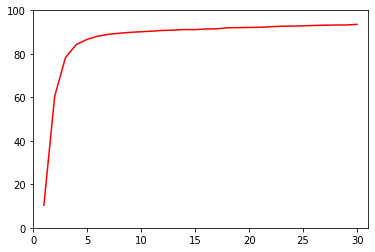

In [14]:
plt.plot(range(1, config.epochs+1), test_accuracy_arr, c='red')
plt.axis([0, config.epochs+1, 0, 100])
plt.show()